# Chagas et al. 2017

[Chagas, M. H. N., Tumas, V., Pena-Pereira, M. A., Machado-de-Sousa, J. P., Dos Santos, A. C., Sanches, R. F., ... & Crippa, J. A. S. (2017). Neuroimaging of major depression in Parkinson's disease: Cortical thickness, cortical and subcortical volume, and spectroscopy findings. Journal of psychiatric research, 90, 40-45.](https://www.sciencedirect.com/science/article/pii/S0022395616301881?via%3Dihub)

## Demographics

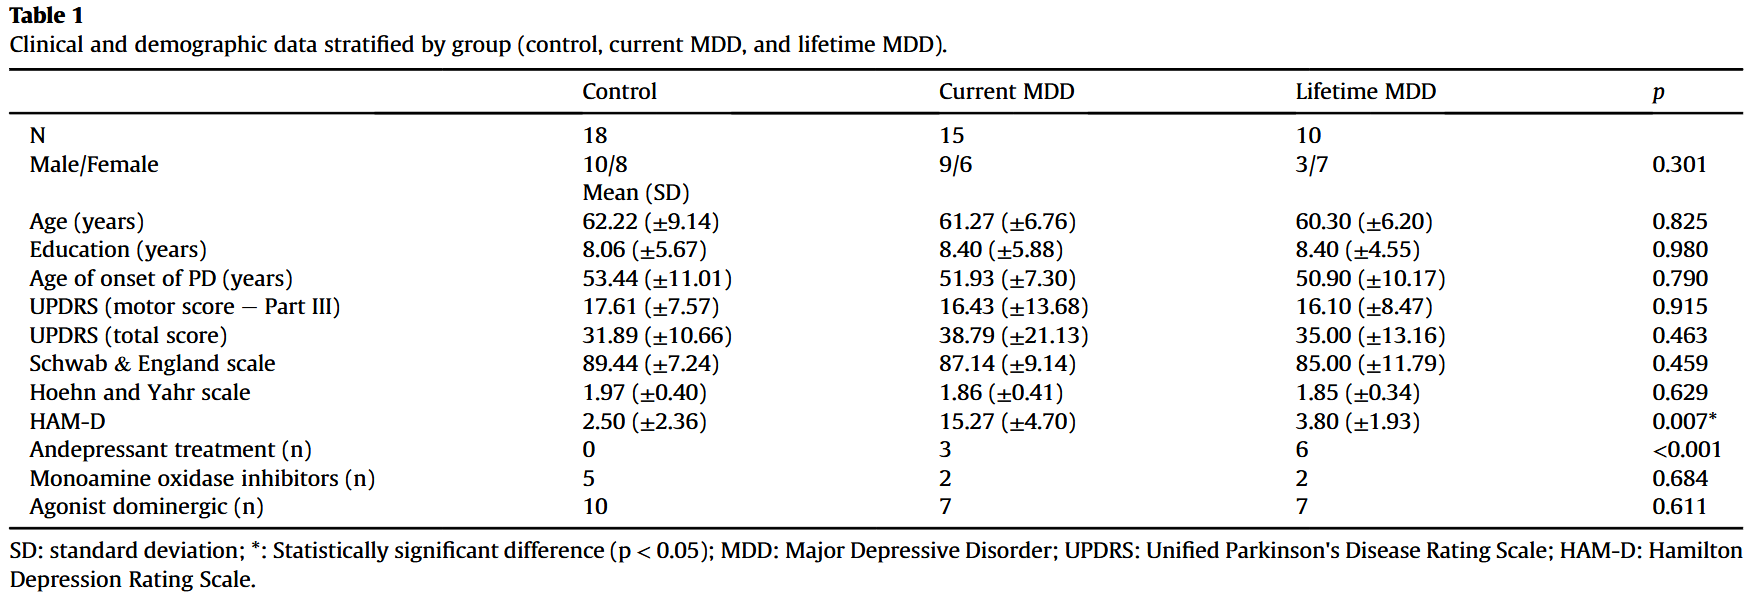

## Results

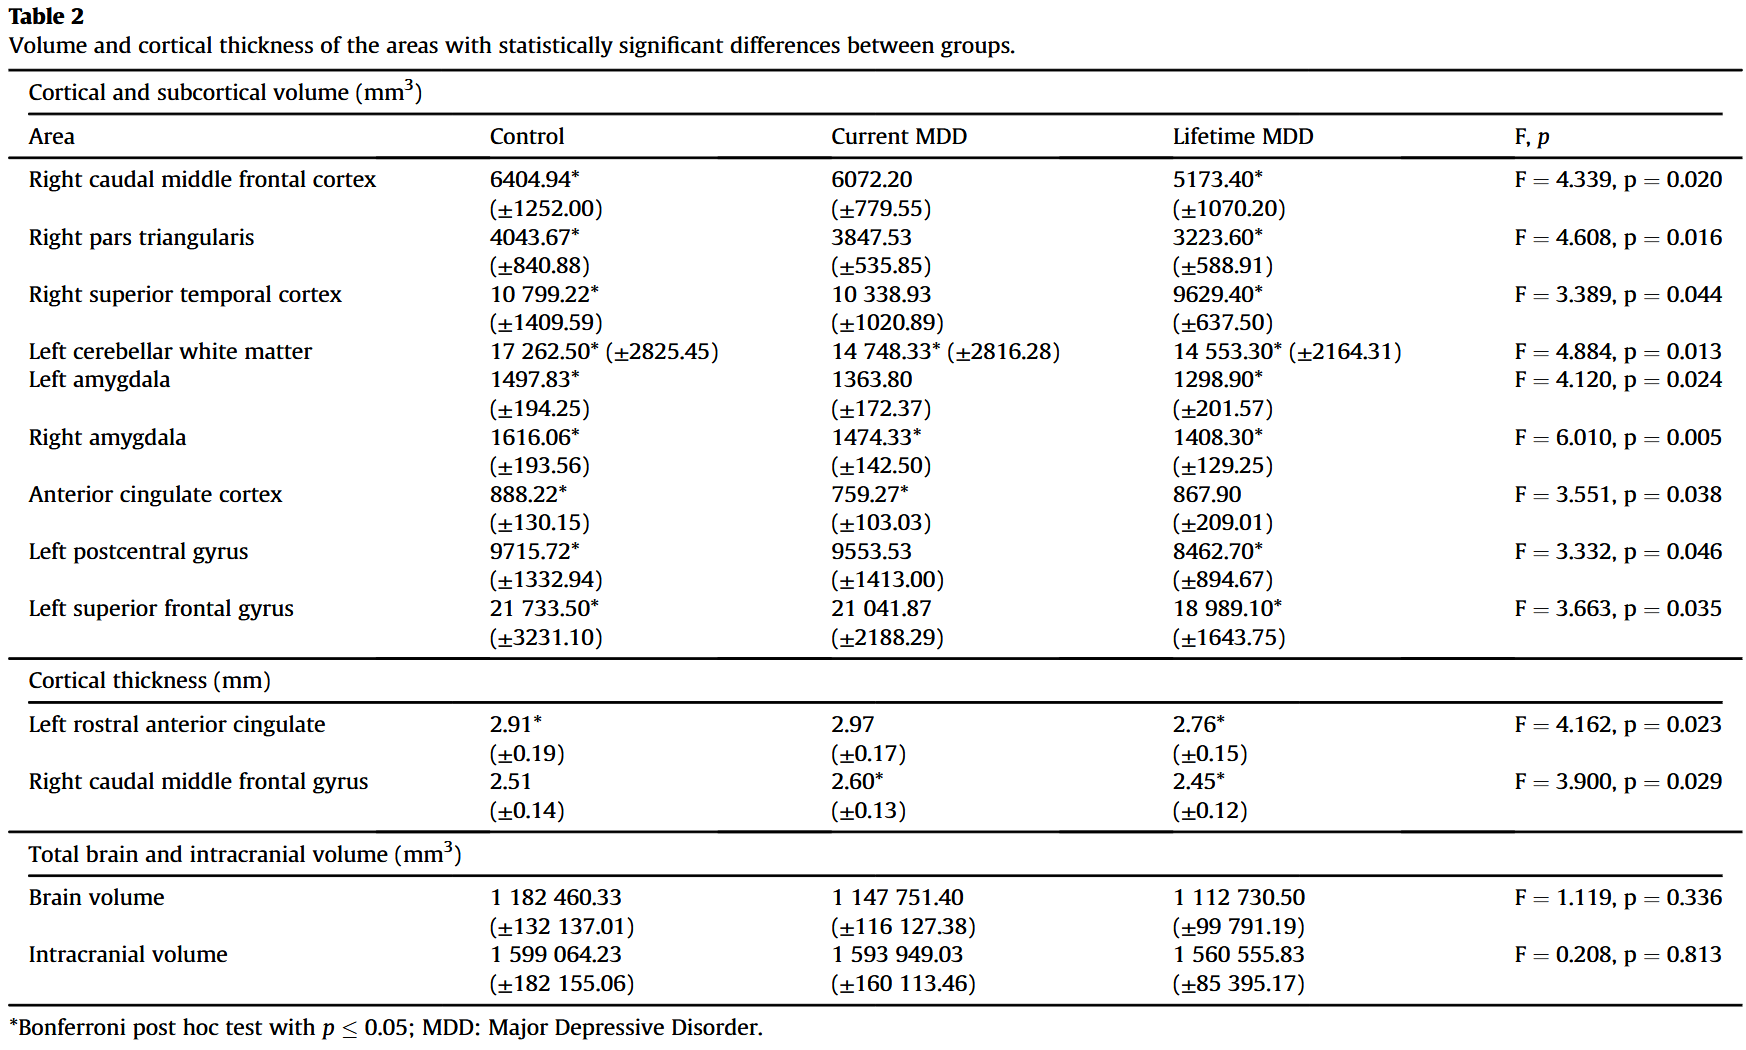

## Consistency analysis

In [30]:
import pandas as pd
from pathlib import Path
from IPython.display import Image

anonymizer = True

root_dir = Path.cwd().parent.parent.parent.parent.resolve()


def anondir(path: Path, prefix=root_dir) -> Path:
    """Anonymize a directory path by replacing user-specific parts with <root>."""
    if not anonymizer:
        return path
    path_str = str(path).replace(str(prefix), "<living-park>")
    return Path(path_str)


print(f"Running in root dir: {anondir(root_dir)}")
npv_dir = root_dir / "npv" / "csv_all"
assert npv_dir.exists(), f"NPV dir does not exist: {anondir(npv_dir)}"
print(f"Using NPV dir: {anondir(npv_dir)}")
data_dir = root_dir / "notebooks" / "papers_data" / "parkinson" / "Chagas_2017"
print(f"Using data dir: {anondir(data_dir)}")
assert data_dir.exists(), f"Data dir does not exist: {anondir(data_dir)}"
figure_dir = root_dir / "figures"
figure_dir.mkdir(parents=True, exist_ok=True)
assert figure_dir.exists(), f"Figure dir does not exist: {anondir(figure_dir)}"
print(f"Using figure dir: {anondir(figure_dir)}")

Running in root dir: <living-park>
Using NPV dir: <living-park>/npv/csv_all
Using data dir: <living-park>/notebooks/papers_data/parkinson/Chagas_2017
Using figure dir: <living-park>/figures


In [31]:
def show_figure(fig, filename, height=1200, width=1000):
    fig.show()
    fig.write_image(figure_dir / filename, height=height, width=width)
    display(Image(figure_dir / filename))

### Load NPV maps

In [32]:
npv_thickness = pd.read_csv(npv_dir / "npv_hc-pd_baseline_thickness.csv")
npv_volume = pd.read_csv(npv_dir / "npv_hc-pd_baseline_volume.csv")
# For caudal anterior cingulate
npv_volume_bil = pd.read_csv(npv_dir / "npv_hc-pd_baseline_volume_bilateral.csv")
npv_subcortical_volume = pd.read_csv(
    npv_dir / "npv_hc-pd_baseline_subcortical_volume.csv"
)

### Formula

In [33]:
import numpy as np
import scipy.stats


# ANCOVA
def std_F(F, npv):
    return 2 * np.sqrt(F) * npv


def std_p_F(F, df, npv):
    return 2 * np.sqrt(F) * scipy.stats.f.pdf(F, dfn=1, dfd=df) * npv


# T-test
def std_t(npv):
    return npv


def std_p_t(t, df, npv):
    return 2 * scipy.stats.t.pdf(np.abs(t), df) * npv


# Partial correlation
def std_r(r, n, npv):
    return np.sqrt((1 - r**2) ** 3 / (n - 1)) * npv


def std_p_r(r, n, npv):
    t = r * np.sqrt((n - 2) / (1 - r**2))
    return 2 * scipy.stats.t.pdf(np.abs(t), n - 2) * np.sqrt((n - 2) / (n - 1)) * npv

In [34]:
import pandas as pd
from scipy.stats import beta
import numpy as np


def beta_params_from_mean_var(mu, var, eps=1e-12):
    """Return (a,b) for Beta by moment matching. Clamps var to < mu(1-mu)."""
    max_var = mu * (1 - mu) - eps
    # Clamp var for non-degenerate cases
    var_clamped = np.minimum(var, max_var)

    # Calculate k for non-degenerate cases
    # Ensure we don't divide by zero if var_clamped becomes zero due to clamping
    # This can happen if mu*(1-mu) is very small and var is also very small but positive.
    # The original code implicitly handles this by setting k=1e6 when var<=0.
    # Here, we ensure that if var_clamped is effectively zero, k is large.
    # A small positive value for the denominator to avoid division by zero for k calculation
    denominator = np.where(var_clamped == 0, eps, var_clamped)
    k_calculated = mu * (1 - mu) / denominator - 1.0
    # Ensure k is not negative, as it should be > 0 for Beta distribution
    k_calculated = np.maximum(k_calculated, eps)  # k must be > 0

    a_calculated = mu * k_calculated
    b_calculated = (1 - mu) * k_calculated

    return a_calculated, b_calculated


def flip_proba_beta(p0, sigma_P, alpha=0.05):
    """
    Flip probability at alpha with P ~ Beta(a,b).
    Provide either sigma_P.
    Works with pandas Series/DataFrames.
    """
    var_P = sigma_P**2
    a, b = beta_params_from_mean_var(p0, var_P)

    # Determine the flip probability based on p0 relative to alpha
    # Use np.where for vectorized conditional logic
    # pflip_non_significant = 1.0 - beta.cdf(alpha, a, b) # if p0 < alpha, flip if P > alpha
    pflip_significant = beta.cdf(alpha, a, b)  # if p0 >= alpha, flip if P <= alpha

    # pflip = np.where(p0 < alpha, pflip_significant, pflip_non_significant)
    pflip = pflip_significant

    # Clip the result to ensure it's within [0, 1]
    return np.clip(pflip, 0.0, 1.0)

In [35]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd


def plot_dumbbell(results, group):
    columns = [
        "region",
        "p_value",
        "npv",
        "std_p",
        "std_p_low",
        "std_p_high",
        "proba_significant",
    ]
    df = results.copy()
    df = df[columns]
    df.rename(
        columns={
            "std_p": "std_p",
            "std_r": "std_r",
            "sig": "sig",
            "p": "p_value",
            "std_p_low": "std_p_low",
            "std_p_high": "std_p_high",
            "proba_significant": "psig",
        },
        inplace=True,
    )
    df["std_p_low"] = df["std_p"] - df["std_p_low"]
    df["std_p_high"] = df["std_p_high"] - df["std_p"]

    col_label = "std_p"

    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=["p-value", "std p-value", "Probability significance"],
    )

    fig_1 = px.scatter(df, x="region", y="p_value")
    # Add lines for each dumbbell
    fig_2 = px.scatter(
        df,
        x="region",
        y="std_p",
        error_y="std_p_low",
        error_y_minus="std_p_high",
        labels="std_p",
    )
    fig_3 = go.Scatter(
        x=df["region"],
        y=df["psig"],
        mode="markers",
        marker_color="black",
        marker_symbol="cross",
        name="Flip probability",
        showlegend=False,
    )

    fig.add_traces(fig_1.data, rows=1, cols=1)
    fig.add_traces(fig_2.data, rows=1, cols=2)
    fig.add_traces(fig_3, rows=1, cols=3)

    fig.update_layout(
        title=f"Group differences ({group})",
        yaxis_title=col_label,
        xaxis_title="Value",
        hovermode="closest",
        height=600,
        width=1400,
    )

    fig.add_hline(y=0.05, line_color="red", line_width=2, row=1, col=1)
    fig.update_yaxes(range=[-0.05, 1.05])

    return fig

## Results

### Table 2 

In [36]:
df = pd.read_csv(data_dir / "table_2.csv")
# volume
df_volume = df[df["metric"] == "volume"]
npv_volume["region"] = npv_volume["hemisphere"] + "-" + npv_volume["region"]
npv_volume = pd.concat([npv_volume, npv_volume_bil])
df_volume = pd.merge(df_volume, npv_volume, on="region")

n_hc = 18
n_pd = 25
n = n_hc + n_pd
df_volume["metric"] = "cortical volume"
df_volume["sample_size"] = n
df_volume["test"] = "F"
df_volume["alpha"] = 0.05
df_volume["std_F"] = std_F(df_volume["F"], df_volume["npv"])
df_volume["std_p"] = std_p_F(df_volume["F"], n, df_volume["npv"])
df_volume["std_p_low"] = std_p_F(df_volume["F"], n, df_volume["npv_CI_low"])
df_volume["std_p_high"] = std_p_F(df_volume["F"], n, df_volume["npv_CI_high"])
df_volume["proba_significant"] = flip_proba_beta(df_volume["p"], df_volume["std_p"])
df_volume.rename(columns={"p": "p_value"}, inplace=True)

In [37]:
plot_dumbbell(df_volume, "Cortical volume")

In [38]:
df = pd.read_csv(data_dir / "table_2.csv")
# subcortical volume
df_subcortical_volume = df[df["metric"] == "subcortical-volume"]
df_subcortical_volume = pd.merge(
    df_subcortical_volume, npv_subcortical_volume, on="region"
)

n_hc = 18
n_pd = 25
n = n_hc + n_pd
df_subcortical_volume["alpha"] = 0.05
df_subcortical_volume["metric"] = "subcortical volume"
df_subcortical_volume["sample_size"] = n
df_subcortical_volume["test"] = "F"
df_subcortical_volume["std_F"] = std_F(
    df_subcortical_volume["F"], df_subcortical_volume["npv"]
)
df_subcortical_volume["std_p"] = std_p_F(
    df_subcortical_volume["F"], n, df_subcortical_volume["npv"]
)
df_subcortical_volume["std_p_low"] = std_p_F(
    df_subcortical_volume["F"], n, df_subcortical_volume["npv_CI_low"]
)
df_subcortical_volume["std_p_high"] = std_p_F(
    df_subcortical_volume["F"], n, df_subcortical_volume["npv_CI_high"]
)
df_subcortical_volume["proba_significant"] = flip_proba_beta(
    df_subcortical_volume["p"], df_subcortical_volume["std_p"]
)
df_subcortical_volume.rename(columns={"p": "p_value"}, inplace=True)

In [39]:
plot_dumbbell(df_subcortical_volume, "Subcortical volume")

In [40]:
df = pd.read_csv(data_dir / "table_2.csv")
# thickness
df_thickness = df[df["metric"] == "thickness"]
npv_thickness["region"] = npv_thickness["hemisphere"] + "-" + npv_thickness["region"]
df_thickness = pd.merge(df_thickness, npv_thickness, on="region")

n_hc = 18
n_pd = 25
n = n_hc + n_pd
df_thickness["alpha"] = 0.05
df_thickness["metric"] = "cortical thickness"
df_thickness["sample_size"] = n
df_thickness["test"] = "F"
df_thickness["std_F"] = std_F(df_thickness["F"], df_thickness["npv"])
df_thickness["std_p"] = std_p_F(df_thickness["F"], n, df_thickness["npv"])
df_thickness["std_p_low"] = std_p_F(df_thickness["F"], n, df_thickness["npv_CI_low"])
df_thickness["std_p_high"] = std_p_F(df_thickness["F"], n, df_thickness["npv_CI_high"])
df_thickness["proba_significant"] = flip_proba_beta(
    df_thickness["p"], df_thickness["std_p"]
)
df_thickness.rename(columns={"p": "p_value"}, inplace=True)

In [41]:
fig = plot_dumbbell(df_thickness, "Cortical thickness")
fig.update_xaxes(tickangle=45)

In [42]:
df = pd.concat([df_subcortical_volume, df_volume, df_thickness], ignore_index=True)
df["study"] = "cross-sectional"
# Assert dataframe contains "proba_significant" and "significant" columns
assert "p_value" in df.columns
assert "proba_significant" in df.columns
assert "significant" in df.columns
assert "sample_size" in df.columns
assert "test" in df.columns
assert "metric" in df.columns
assert "study" in df.columns
df.to_csv(data_dir / "uncertainty.csv", index=False)